In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from scipy.io import arff
# Add these new imports
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV, cross_val_score
from statistics import mean, stdev
import matplotlib.pyplot as plt

In [2]:
 # Load the ARFF file
data, meta = arff.loadarff('Training Dataset.arff')

# Convert to pandas DataFrame
df = pd.DataFrame(data)

for column in df.columns:
    df[column] = df[column].astype(str).str.replace("b'", "").str.replace("'", "").astype(int)
    
# Display first few rows and basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset Shape: (11055, 31)

First few rows:


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [3]:
X = df.drop('Result', axis=1)  # Assuming 'Result' is the target column
y = df['Result'] 

In [4]:
# Diagnostic checks
print("Unique values in Result column:", df['Result'].unique())
print("\nResult column info:")
print(df['Result'].info())
print("\nSample of Result column values:")
print(df['Result'].head(10))

# Check for any non-numeric or special values
print("\nChecking for any non-numeric values:")
print(df['Result'].apply(lambda x: type(x)))

# Make sure all values are proper integers
df['Result'] = df['Result'].astype(int)
y = df['Result'].astype(int)

# Now proceed with the split and model training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Unique values in Result column: [-1  1]

Result column info:
<class 'pandas.core.series.Series'>
RangeIndex: 11055 entries, 0 to 11054
Series name: Result
Non-Null Count  Dtype
--------------  -----
11055 non-null  int64
dtypes: int64(1)
memory usage: 86.5 KB
None

Sample of Result column values:
0   -1
1   -1
2   -1
3   -1
4    1
5    1
6   -1
7   -1
8    1
9   -1
Name: Result, dtype: int64

Checking for any non-numeric values:
0        <class 'int'>
1        <class 'int'>
2        <class 'int'>
3        <class 'int'>
4        <class 'int'>
             ...      
11050    <class 'int'>
11051    <class 'int'>
11052    <class 'int'>
11053    <class 'int'>
11054    <class 'int'>
Name: Result, Length: 11055, dtype: object


In [5]:
# Define partition ratios and parameter grid
partition_ratios = [
    (0.2, 0.8),  # 20/80
    (0.5, 0.5),  # 50/50
    (0.8, 0.2)   # 80/20
]

param_grid = {
    'C': [0.1, 1, 10, 100],
    'class_weight': ['balanced'],
    'max_iter': [1000]
}

def run_trial(X, y, train_size, random_state=42):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=random_state, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    
    # Find best parameters using GridSearchCV
    svm_model = LinearSVC(dual=False)
    grid_search = GridSearchCV(
        svm_model,
        param_grid,
        cv=kf,
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train_scaled, y_train)
    
    # Get best model
    best_svm = grid_search.best_estimator_
    
    # Calculate scores
    train_score = best_svm.score(X_train_scaled, y_train)
    test_score = best_svm.score(X_test_scaled, y_test)
    val_scores = cross_val_score(
        best_svm, 
        X_train_scaled, 
        y_train, 
        cv=kf,
        scoring='balanced_accuracy'
    )
    
    # Get predictions for detailed metrics
    y_pred = best_svm.predict(X_test_scaled)
    
    return {
        'train_score': train_score,
        'validation_score': mean(val_scores),
        'test_score': test_score,
        'best_params': grid_search.best_params_,
        'classification_report': classification_report(y_test, y_pred)
    }

In [6]:
# Run experiments for each partition ratio
results = {}
for train_size, test_size in partition_ratios:
    ratio_results = []
    print(f"\nRunning experiments for {train_size*100:.0f}/{test_size*100:.0f} split")
    
    for trial in range(3):
        print(f"Trial {trial + 1}/3...")
        trial_results = run_trial(X, y, train_size, random_state=42+trial)
        ratio_results.append(trial_results)
    
    # Calculate averages
    avg_results = {
        'avg_train_score': mean([r['train_score'] for r in ratio_results]),
        'avg_validation_score': mean([r['validation_score'] for r in ratio_results]),
        'avg_test_score': mean([r['test_score'] for r in ratio_results]),
        'std_train_score': stdev([r['train_score'] for r in ratio_results]),
        'std_validation_score': stdev([r['validation_score'] for r in ratio_results]),
        'std_test_score': stdev([r['test_score'] for r in ratio_results]),
        'individual_trials': ratio_results
    }
    
    results[f"{train_size*100:.0f}/{test_size*100:.0f}"] = avg_results


Running experiments for 20/80 split
Trial 1/3...
Trial 2/3...
Trial 3/3...

Running experiments for 50/50 split
Trial 1/3...


C:\Users\Aden\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Trial 2/3...
Trial 3/3...

Running experiments for 80/20 split
Trial 1/3...
Trial 2/3...
Trial 3/3...



RESULTS BY SPLIT RATIO

Results for 20/80 split:
Average Training Score: 0.9270 ± 0.0041
Average Validation Score: 0.9228 ± 0.0031
Average Test Score: 0.9263 ± 0.0015

Best parameters for each trial:
Trial 1: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000}
Trial 2: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000}
Trial 3: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000}

Detailed Classification Report (last trial):
              precision    recall  f1-score   support

          -1       0.93      0.91      0.92      3918
           1       0.93      0.94      0.94      4926

    accuracy                           0.93      8844
   macro avg       0.93      0.93      0.93      8844
weighted avg       0.93      0.93      0.93      8844


Results for 50/50 split:
Average Training Score: 0.9276 ± 0.0030
Average Validation Score: 0.9247 ± 0.0035
Average Test Score: 0.9258 ± 0.0025

Best parameters for each trial:
Trial 1: {'C': 0.1, 'class_weight': 'balanced', 'ma

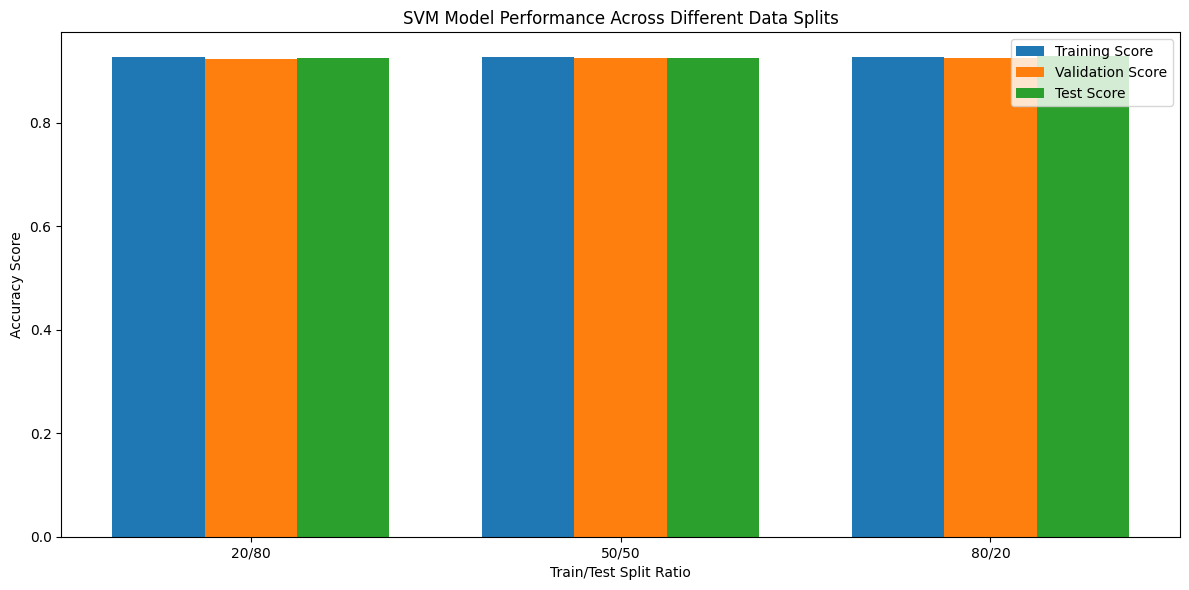

In [7]:
# Print detailed results
print("\n" + "="*50)
print("RESULTS BY SPLIT RATIO")
print("="*50)

for split, res in results.items():
    print(f"\nResults for {split} split:")
    print(f"Average Training Score: {res['avg_train_score']:.4f} ± {res['std_train_score']:.4f}")
    print(f"Average Validation Score: {res['avg_validation_score']:.4f} ± {res['std_validation_score']:.4f}")
    print(f"Average Test Score: {res['avg_test_score']:.4f} ± {res['std_test_score']:.4f}")
    
    # Print best parameters for each trial
    print("\nBest parameters for each trial:")
    for i, trial in enumerate(res['individual_trials']):
        print(f"Trial {i+1}: {trial['best_params']}")
        
    # Print classification report for the last trial
    print("\nDetailed Classification Report (last trial):")
    print(trial['classification_report'])

# Visualize results
plt.figure(figsize=(12, 6))
splits = list(results.keys())
train_scores = [res['avg_train_score'] for res in results.values()]
val_scores = [res['avg_validation_score'] for res in results.values()]
test_scores = [res['avg_test_score'] for res in results.values()]

x = np.arange(len(splits))
width = 0.25

plt.bar(x - width, train_scores, width, label='Training Score')
plt.bar(x, val_scores, width, label='Validation Score')
plt.bar(x + width, test_scores, width, label='Test Score')

plt.xlabel('Train/Test Split Ratio')
plt.ylabel('Accuracy Score')
plt.title('SVM Model Performance Across Different Data Splits')
plt.xticks(x, splits)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# After scaling, convert to DataFrame with feature names
X_train_scaled = pd.DataFrame(
    X_train_scaled, 
    columns=X.columns  # Use columns from the original DataFrame
)
X_test_scaled = pd.DataFrame(
    X_test_scaled, 
    columns=X.columns  # Use columns from the original DataFrame
)


In [9]:
# Train SVM model
clf = LinearSVC(
    dual=False,
    max_iter=1000,
    random_state=42  # Match random state used in RF
)
clf.fit(X_train_scaled, y_train)

LinearSVC(dual=False, random_state=42)

In [10]:
y_pred_simple = clf.predict(X_test_scaled)

In [11]:
y_pred = clf.predict(X_test)

In [12]:
# Evaluate the model (matching output format of other notebooks)
accuracy_simple = accuracy_score(y_test, y_pred)
print("\nSimplified Model Results:")
print(f"Accuracy: {accuracy_simple:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Simplified Model Results:
Accuracy: 0.9159

Classification Report:
              precision    recall  f1-score   support

          -1       0.88      0.93      0.91       956
           1       0.94      0.91      0.92      1255

    accuracy                           0.92      2211
   macro avg       0.91      0.92      0.91      2211
weighted avg       0.92      0.92      0.92      2211

